## Goal of the Competition
The goal of this competition is to predict if a person has any of three medical conditions. You are being asked to predict if the person has one or more of any of the three medical conditions (Class 1), or none of the three medical conditions (Class 0). You will create a model trained on measurements of health characteristics.

In [183]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import scipy.stats as stats


from scipy.cluster.hierarchy import linkage
from scipy.spatial.distance import squareform
from scipy.stats import gaussian_kde
from scipy.stats import probplot

from plotly.subplots import make_subplots
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import brier_score_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import Binarizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler

In [184]:
import mlflow
mlflow.set_tracking_uri(uri = 'http://127.0.0.1:5000')


## EDA

In [185]:
# load the dataset
df = pd.read_csv(r"C:\Users\dana_\Data Science Notebooks\ml-project-data\train.csv")

In [186]:
df.sample(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
417,a46b439e1eac,0.615312,5379.22198,117.667299,30.477577,8.138688,5.590029,0.025578,11.129332,1.229900,...,7.861648,0.73225,0.426699,17.850538,72.611063,20268.142790,27.286093,48.770264,0.173909,0
111,2d7ba928287d,1.341722,3965.99280,128.318406,28.049529,8.138688,9.098193,0.051156,16.845246,1.229900,...,0.173229,1.69070,0.426699,34.138340,72.611063,59180.211250,35.929976,4.537008,21.978000,0
183,4671650635ab,0.354659,5368.11176,85.200147,30.895672,13.540008,6.688545,0.032886,13.524092,3.120432,...,5.928993,1.51206,0.067730,19.841166,155.957644,6206.977188,19.762231,31.041468,0.073686,0
240,6002d5f39711,0.470030,7549.83009,102.583311,35.296509,13.775988,5.421708,0.025578,13.001026,5.330738,...,10.096394,1.60312,0.480883,14.845992,576.230778,11483.064390,22.779962,110.932932,0.231623,0
547,df956c379776,0.371751,4517.85686,107.469060,29.978960,8.138688,7.716189,0.025578,22.920374,1.229900,...,0.173229,1.35372,1.171729,17.924954,72.611063,119643.014900,33.362486,50.629820,21.978000,0
295,7530ec447c5d,0.264926,2384.14044,85.200147,26.522708,15.663828,6.121569,0.025578,12.969516,7.997864,...,0.173229,1.36822,0.067730,22.520142,693.252567,22495.512620,21.481333,16.967484,21.978000,0
270,68c35486588c,0.303383,1691.60662,95.546439,113.124119,8.138688,3.871383,0.025578,8.520304,1.229900,...,0.265776,0.49706,0.284466,13.497202,72.611063,4378.430862,27.014460,22.692756,2.970000,0
540,da6c7e4e124d,0.388843,2185.51894,85.200147,93.473654,8.138688,6.493647,0.025578,8.028748,1.229900,...,1.529431,1.13767,0.067730,8.269478,72.611063,8089.194681,36.808132,43.410216,2.019600,0
152,3c299fce6b56,0.341840,2392.13370,85.200147,10.350174,8.138688,10.090401,0.025578,10.007576,1.229900,...,0.173229,0.49706,0.067730,34.370890,125.372128,30501.026120,31.304773,41.416916,21.978000,0


In [187]:
df.shape

(617, 58)

In [188]:
df.describe()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
count,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,617.000000,...,616.000000,617.000000,615.000000,617.000000,617.000000,617.000000,617.000000,617.000000,616.000000,617.000000
mean,0.477149,3502.013221,118.624513,38.968552,10.128242,5.545576,0.060320,10.566447,8.053012,5350.388655,...,5.433199,3.533905,0.421501,20.724856,131.714987,14679.595398,31.489716,50.584437,8.530961,0.175041
std,0.468388,2300.322717,127.838950,69.728226,10.518877,2.551696,0.416817,4.350645,65.166943,3021.326641,...,11.496257,50.181948,1.305365,9.991907,144.181524,19352.959387,9.864239,36.266251,10.327010,0.380310
min,0.081187,192.593280,85.200147,3.177522,8.138688,0.699861,0.025578,3.396778,1.229900,1693.624320,...,0.173229,0.497060,0.067730,4.102182,72.611063,13.038894,9.432735,0.897628,0.001129,0.000000
25%,0.252107,2197.345480,85.200147,12.270314,8.138688,4.128294,0.025578,8.129580,1.229900,4155.702870,...,0.173229,0.497060,0.067730,14.036718,72.611063,2798.992584,25.034888,23.011684,0.124392,0.000000
50%,0.354659,3120.318960,85.200147,20.533110,8.138688,5.031912,0.025578,10.461320,1.229900,4997.960730,...,3.028141,1.131000,0.250601,18.771436,72.611063,7838.273610,30.608946,41.007968,0.337827,0.000000
75%,0.559763,4361.637390,113.739540,39.139886,8.138688,6.431634,0.036845,12.969516,5.081244,6035.885700,...,6.238814,1.512060,0.535067,25.608406,127.591671,19035.709240,36.863947,67.931664,21.978000,0.000000
max,6.161666,28688.187660,1910.123198,630.518230,178.943634,38.270880,10.315851,38.971568,1463.693448,53060.599240,...,137.932739,1244.227020,31.365763,135.781294,1497.351958,143790.071200,81.210825,191.194764,21.978000,1.000000


In [189]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 58 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Id      617 non-null    object 
 1   AB      617 non-null    float64
 2   AF      617 non-null    float64
 3   AH      617 non-null    float64
 4   AM      617 non-null    float64
 5   AR      617 non-null    float64
 6   AX      617 non-null    float64
 7   AY      617 non-null    float64
 8   AZ      617 non-null    float64
 9   BC      617 non-null    float64
 10  BD      617 non-null    float64
 11  BN      617 non-null    float64
 12  BP      617 non-null    float64
 13  BQ      557 non-null    float64
 14  BR      617 non-null    float64
 15  BZ      617 non-null    float64
 16  CB      615 non-null    float64
 17  CC      614 non-null    float64
 18  CD      617 non-null    float64
 19  CF      617 non-null    float64
 20  CH      617 non-null    float64
 21  CL      617 non-null    float64
 22  CR

In [190]:
#missing values
print(df.isna().sum()[df.isna().sum() > 0])

BQ    60
CB     2
CC     3
DU     1
EL    60
FC     1
FL     1
FS     2
GL     1
dtype: int64


In [191]:
df.dropna()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,0.173229,1.89486,1.395238,16.911036,246.093155,10960.364830,38.380254,41.007968,21.978000,0
612,fd3dafe738fd,0.149555,3130.05946,123.763599,9.513984,13.020852,3.499305,0.077343,8.545512,2.804172,...,0.173229,1.26092,0.067730,8.967128,217.148554,8095.932828,24.640462,69.191944,21.978000,0
613,fd895603f071,0.435846,5462.03438,85.200147,46.551007,15.973224,5.979825,0.025882,12.622906,3.777550,...,10.223150,1.24236,0.426699,35.896418,496.994214,3085.308063,29.648928,124.808872,0.145340,0
614,fd8ef6377f76,0.427300,2459.10720,130.138587,55.355778,10.005552,8.070549,0.025578,15.408390,1.229900,...,0.173229,0.49706,0.067730,19.962092,128.896894,6474.652866,26.166072,119.559420,21.978000,0


In [192]:
df['EJ'].value_counts()

EJ
B    395
A    222
Name: count, dtype: int64

In [193]:
df['EJ']. replace({'B': 1, 'A': 0}, inplace=True)

In [194]:
print(df['Class'].value_counts())

Class
0    509
1    108
Name: count, dtype: int64


## Baselining and initial model building

In [195]:
# Define variables 
X = df.drop(['Id','Class'], axis=1)
y = df['Class']

# Split the data into training and test sets for model building
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [ ]:
# This function generates undersampled dataset.
def random_under_sampler(df):
    # Calculate the number of samples for each label. 
    neg, pos = np.bincount(df['Class'])

    # Choose the samples with class label `1`.
    one_df = df.loc[df['Class'] == 1] 
    # Choose the samples with class label `0`.
    zero_df = df.loc[df['Class'] == 0]
    # Select `pos` number of negative samples.
    # This makes sure that we have equal number of samples for each label.
    zero_df = zero_df.sample(n=pos)

    # Join both label dataframes.
    undersampled_df = pd.concat([zero_df, one_df])

    # Shuffle the data and return
    return undersampled_df.sample(frac = 1)

In [196]:
# Train and evaluate Random Forest classifier
rf_classifier = RandomForestClassifier(random_state = 50)
rf_classifier.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier.predict_proba(X_test_scaled)

train_acc = accuracy_score(y_train, rf_classifier.predict(X_train_scaled))
test_acc = accuracy_score(y_test, rf_classifier.predict(X_test_scaled))
print('Accuracy train:', train_acc)
print('Accuracy test:', test_acc)
print('ROC score', roc_auc_score(y_test, rf_classifier.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 1.0
Accuracy test: 0.9354838709677419
ROC score 0.9515199161425577


In [197]:
# Train and evaluate XGBoost classifier
xgb_classifier = XGBClassifier(random_state = 50)
xgb_classifier.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_classifier.predict_proba(X_test_scaled)

train_acc = accuracy_score(y_train, xgb_classifier.predict(X_train_scaled))
test_acc = accuracy_score(y_test, xgb_classifier.predict(X_test_scaled))
print('Accuracy train:', train_acc)
print('Accuracy test:', test_acc)
print('ROC score', roc_auc_score(y_test, xgb_classifier.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 1.0
Accuracy test: 0.9516129032258065
ROC score 0.9853249475890986


In [198]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(y_test, xgb_classifier.predict(X_test_scaled))
cm2 = confusion_matrix(y_test, rf_classifier.predict(X_test_scaled))

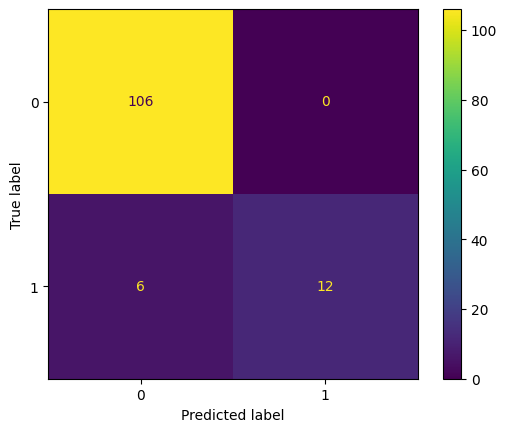

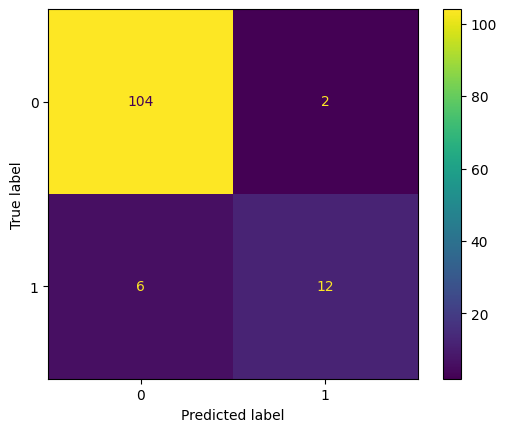

In [199]:
from sklearn.metrics import ConfusionMatrixDisplay 
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels= xgb_classifier.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels= rf_classifier.classes_)

disp1.plot()
disp2.plot()


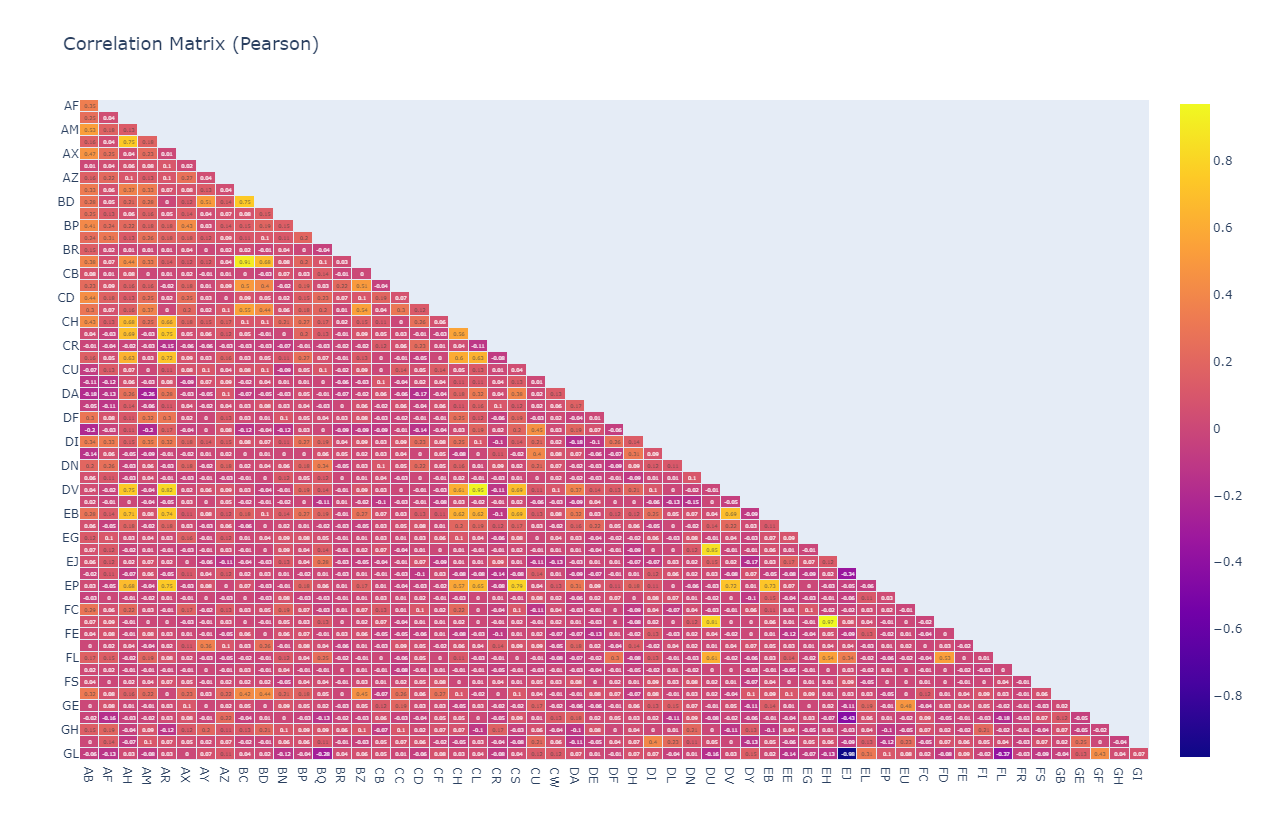

In [200]:
pearson_corr = (df.drop("Class", axis=1).corr(numeric_only=True, method="pearson").round(2))

mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
lower_triangular_corr = (
    pearson_corr.mask(mask)
    .dropna(axis="index", how="all")
    .dropna(axis="columns", how="all")
)
heatmap = go.Heatmap(
    z=lower_triangular_corr,
    x=lower_triangular_corr.columns,
    y=lower_triangular_corr.index,
    text=lower_triangular_corr.fillna(""),
    texttemplate="%{text}",
    xgap=1,
    ygap=1,
    showscale=True,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    #font_color=FONT_COLOR,
    title="Correlation Matrix (Pearson)",
    title_font_size=18,
    width=840,
    height=840,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
)
fig.show()

In [201]:
xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=50, ...)

In [202]:
rf_classifier

RandomForestClassifier(random_state=50)

In [203]:
rf_classifier_adjusted = RandomForestClassifier(random_state=50, n_estimators=50, criterion='gini', max_depth=5)
rf_classifier_adjusted.fit(X_train_scaled, y_train)
y_pred_rf = rf_classifier_adjusted.predict_proba(X_test_scaled)
train_acc_adj = accuracy_score(y_train, rf_classifier_adjusted.predict(X_train_scaled))
test_acc_adj = accuracy_score(y_test, rf_classifier_adjusted.predict(X_test_scaled))
print('Accuracy train:', train_acc_adj)
print('Accuracy test:', test_acc_adj)
print('ROC score', roc_auc_score(y_test, rf_classifier_adjusted.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 0.9776876267748479
Accuracy test: 0.9354838709677419
ROC score 0.9454926624737944


In [204]:
# Calculate the number of samples for each label.
neg, pos = np.bincount(df['Class'])

# Calculate total samples.
total = neg + pos

# Calculate the weight for each label.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.61
Weight for class 1: 2.86


In [205]:
model = RandomForestClassifier(random_state=50, n_estimators=50, criterion='gini', max_depth=5, class_weight = weight)
model.fit(X_train_scaled, y_train)
y_pred_rf = model.predict_proba(X_test_scaled)
tr_acc_adj = accuracy_score(y_train, model.predict(X_train_scaled))
tst_acc_adj = accuracy_score(y_test, model.predict(X_test_scaled))
print('Accuracy train:', tr_acc_adj)
print('Accuracy test:', tst_acc_adj)
print('ROC score', roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:,1]))

Accuracy train: 0.9858012170385395
Accuracy test: 0.9435483870967742
ROC score 0.9544025157232705


C:\Users\dana_\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:486: UserWarning:

X has feature names, but RandomForestClassifier was fitted without feature names



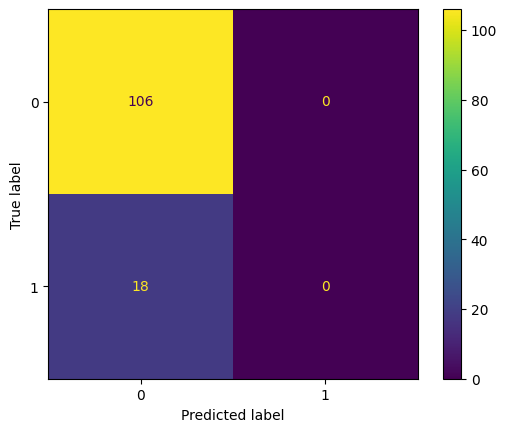

In [206]:
cm = confusion_matrix(y_test, model.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels= model.classes_)
disp.plot()

In [207]:
from sklearn.datasets import make_classification

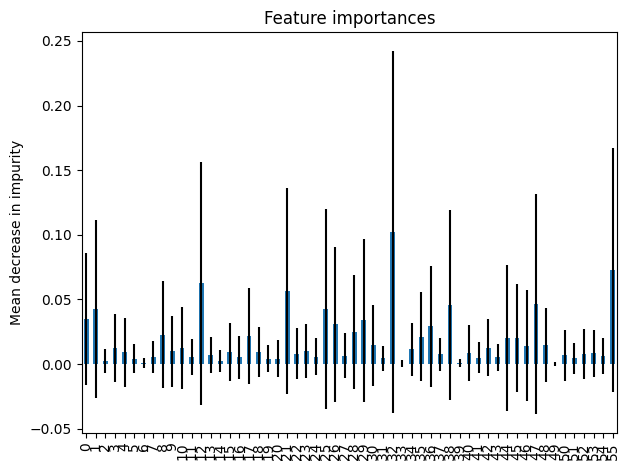

In [208]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt


#feature_names = [f"feature {i}" for i in range(X.shape[1])]
#forest = RandomForestClassifier(random_state = 0)
#forest.fit(X_train, y_train)
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
forest_importances = pd.Series(importances)# index = feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [209]:
model.feature_importances_

array([0.03520532, 0.04244713, 0.00249525, 0.01256185, 0.00909691,
       0.00417845, 0.00087478, 0.0052597 , 0.02275811, 0.0099606 ,
       0.01256297, 0.00547559, 0.06259026, 0.00689065, 0.0022866 ,
       0.00926563, 0.00520491, 0.02194264, 0.00917371, 0.00410842,
       0.00416076, 0.05653728, 0.00822739, 0.00986099, 0.00570687,
       0.04265312, 0.03091227, 0.00646777, 0.02479526, 0.03384495,
       0.0145057 , 0.0044907 , 0.10247424, 0.00046726, 0.01133643,
       0.02127371, 0.02940459, 0.00751036, 0.04587996, 0.00065476,
       0.00861949, 0.00507614, 0.01285709, 0.00521829, 0.02029093,
       0.02012941, 0.01438331, 0.04652151, 0.01460121, 0.00034744,
       0.00688669, 0.00443747, 0.00762147, 0.00830888, 0.00629536,
       0.07290145])

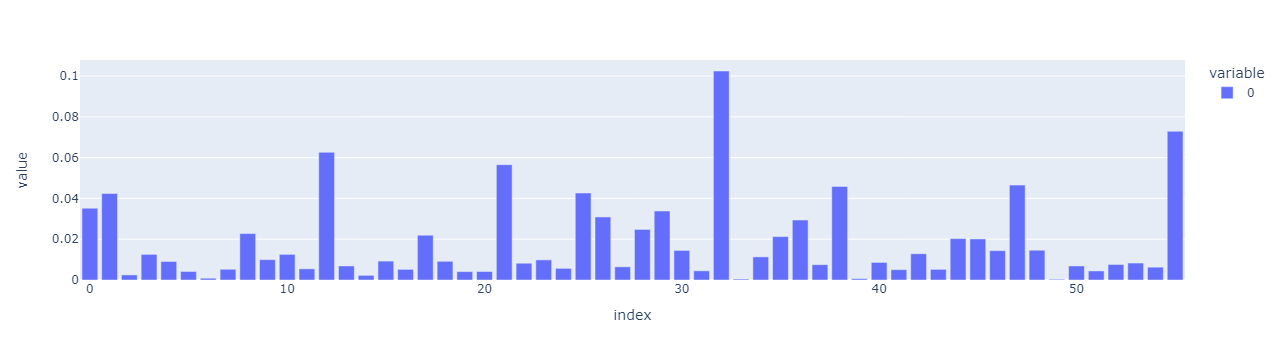

In [210]:
fig = px.bar(model.feature_importances_)
fig.show()